In [2]:
from __future__ import division, print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.ascii as at
import astropy.io.fits as fits
import astropy.table as table
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import palettable

import K2fov.projection as proj
import K2fov.fov as fov
from K2fov.K2onSilicon import angSepVincenty,getRaDecRollFromFieldnum

from hypra.utils import cat_match, cat_io, k2utils
# from hypra.plot import color_mag
import convertmass

In [3]:
pdat,pobs,pobsnr,pobsr = cat_io.get_data("P")

In [4]:
hdat,hobs,hobsnr,hobsr = cat_io.get_data("H")
print(hdat.dtype)
hpos = SkyCoord(hdat["RA"],hdat["DEC"],unit=u.degree)

(numpy.record, [('RA', '>f8'), ('DEC', '>f8'), ('ASAS_ID', 'S13'), ('HIP_ID', 'S9'), ('KUNDERT_MATCH', '>f4'), ('KUNDERT_RA', '>f4'), ('KUNDERT_DEC', '>f4'), ('KUNDERT_PROT', '>f4'), ('KUNDERT_OBS', '>f4'), ('KUNDERT_SPT', 'S5'), ('ROESER_MATCH', '>i4'), ('ROESER_PMRA', '>f4'), ('ROESER_PMRA_ERR', '>f4'), ('ROESER_PMDEC', '>f4'), ('ROESER_PMDEC_ERR', '>f4'), ('ROESER_PARALLAX', '>f4'), ('ROESER_PARALLAX_ERR', '>f4'), ('ROESER_DISTANCE', '>f4'), ('ROESER_RV', '>f4'), ('ROESER_VPAR', '>f4'), ('ROESER_VPAR_ERR', '>f4'), ('ROESER_VPER', '>f4'), ('ROESER_VPER_ERR', '>f4'), ('ROESER_MASS', '>f4'), ('TWOMASSNAME', 'S16'), ('TWOMASS_RA', '>f8'), ('TWOMASS_DEC', '>f8'), ('TWOMASS_J', '>f4'), ('TWOMASS_JERR', '>f4'), ('TWOMASS_H', '>f4'), ('TWOMASS_HERR', '>f4'), ('TWOMASS_K', '>f4'), ('TWOMASS_KERR', '>f4'), ('TWOMASS_FLAG', 'S3'), ('TWOMASS_PHOT_FLAG', 'S5'), ('TWOMASS_SEP_OPT', '>f4'), ('TWOMASS_B', '>f4'), ('TWOMASS_VR', '>f4'), ('DELORME_MATCH', '>i4'), ('SWASP_ID', 'S25'), ('USNO_ID', 'S12

In [5]:
# Match EPIC IDs
epic_list = at.read("mast_search_13064.csv",data_start=2)
print(epic_list.dtype)
mpos = SkyCoord(epic_list["RA (J2000)"], epic_list["Dec (J2000)"],
               unit=(u.hourangle,u.degree))

[('K2 ID', '<i8'), ('Dataset Name', '<U17'), ('Campaign', '<i8'), ('Object type', '<U14'), ('RA (J2000)', '<U12'), ('Dec (J2000)', '<U12'), ('Target Type', '<U2'), ('Ref', '<i8'), ('Actual Start Time', '<U19'), ('Actual End Time', '<U19'), ('Investigation ID', '<U103'), ('R Mag', '<f8'), ('R Mag Err', '<f8'), ('J Mag', '<f8'), ('J Mag Err', '<f8'), ('KEP Mag', '<f8'), ('Kep Flag', '<U3'), ('Hip ID', '<i8'), ('Tyc ID', '<U11'), ('SDSS ID', '<U20'), ('UCAC ID', '<U10'), ('2MASS ID', '<U16'), ('2MASS Flag', '<U19'), ('Module', '<i8'), ('Output', '<i8'), ('Channel', '<i8'), ('High-Level Science Products', '<i8')]


In [6]:
import assemble_periods

output = assemble_periods.get_c13_periods()

132 K2 targets
[]
[]
116 K2 stars with periods
11 with secondary periods at peak separations > 0.2
plus 1 with closer secondary peaks
38 with blended neighbors, or 28.8\%
45 blend/multi
93  new K2 periods
23  with literature periods
75  high quality new K2 periods
10  low quality new K2 periods as flagged by me
8  low quality new K2 periods from not-clean periodograms (but I flagged them good)
1  low quality new K2 periods as flagged by me AND the periodograms

3  with no K2 detection 2.272727272727273 %
3 alternate count of no detections

I removed 13 9.848484848484848 % leaving 116
18  stars where the highest peak doesn't look real
Originally 132 remove 3 and 13 leave 116 

Pre-K2: 139
Total rotators: 232


In [9]:
[pperiods,pperiods_secondary,powers_secondary,
 quality_secondary,pflag,pmass0,pqual,pbad,ppower,pthreshold,
 pharm,pblend,pperiods_allk2,pperiods_onlyk2] = output

In [31]:
gaia_tab = at.read("Gaia_Comb_Table.csv")
print(gaia_tab.dtype)
print(len(gaia_tab))

[('HYADES_IDX', '<i8'), ('RAJ2000', '<f8'), ('DEJ2000', '<f8'), ('GOLDMAN_PMRA', '<f8'), ('GOLDMAN_PMDE', '<f8'), ('ROESER_PMRA', '<f8'), ('ROESER_PMDEC', '<f8'), ('HIP', '<U8'), ('2MASS', '<U16'), ('Jmag', '<f8'), ('e_Jmag', '<f8'), ('Hmag', '<f8'), ('e_Hmag', '<f8'), ('Kmag', '<f8'), ('e_Kmag', '<f8'), ('TWOMASS_PHOT_FLAG', '<U1'), ('Bmag', '<f8'), ('VRmag', '<f8'), ('SWASP', '<U25'), ('UCAC', '<U10'), ('UCAC_R', '<f8'), ('UCAC_RERR', '<f8'), ('UCAC_I', '<f8'), ('UCAC_IERR', '<f8'), ('SDSS_R', '<f8'), ('SDSS_RERR', '<f8'), ('SDSS_I', '<f8'), ('SDSS_IERR', '<f8'), ('HIP_PLX', '<f8'), ('HIP_E_PLX', '<f8'), ('RPRIME', '<f8'), ('RPRIME_SOURCE', '<U1'), ('[RSP2011]', '<i8'), ('GOLDMAN_PLX', '<f8'), ('GOLDMAN_E_PLX', '<f8'), ('GOLDMAN_RMED', '<f8'), ('GOLDMAN_E_RMED', '<f8'), ('GOLDMAN_IMED', '<f8'), ('GOLDMAN_E_IMED', '<f8'), ('EPIC', '<i8'), ('DR2Name', '<U28'), ('RA_ICRS', '<f8'), ('e_RA_ICRS', '<f8'), ('DE_ICRS', '<f8'), ('e_DE_ICRS', '<f8'), ('Source', '<i8'), ('Epoch', '<f8'), ('Plx'

# A few definitions

In [11]:
poster_figure = (12,7)
talk_figure = (10,6.5)
single_figure = (8,8)
double_figure = (13,6)
double_stacked = (6,13)
triple_stacked = (6,14)
quad_square = (13,10)
proposal_figure = (10,5.5)

std_ms = 8
std_mew = 1.25

In [12]:
# cmap = plt.cm.viridis
# old_color = plt.cm.Greys(0.5)
# k2_color = "Crimson"

cmap = colors.ListedColormap(palettable.colorbrewer.qualitative.Dark2_6.mpl_colors)
cmap_qual = palettable.colorbrewer.qualitative.Dark2_7.mpl_colors
old_color = plt.cm.Greys(0.4)
k2_color = cmap_qual[1]
# matt_color = cmap_qual[3]
# brown_color = cmap_qual[2]
# print(brown_color)

## Period-mass plot

In [13]:
from hypra.plot import period_mass

In [14]:
def calc_mass_unc(mK,mK_err,dist,dist_err):
    # dmod = m-M = 5*log10(d) - 5
    # M = m-dmod = m - 5*log10(d) + 5
    # dM/dd = -5/(d*ln(10))
    dmod = 5.0*np.log10(dist) - 5
    MK = mK - dmod
    
    bad = np.where(mK<-99)[0]
    MK[bad] = -9999

    if type(mK_err)==np.ndarray:
        mK_err_sq = mK_err**2 
    else:
        # actually a fraction, but real errors
        mK_err_sq = (mK_err*mK)**2

    dist_err_sq = (dist_err * 5.0 / (dist * np.log(10.0)))**2

    sigma_MK = np.sqrt(mK_err_sq + dist_err_sq)
    #print(sigma_MK)

    MK_low =  MK + sigma_MK #dimmer/lower mass
    MK_high = MK - sigma_MK #brighter/higher mass
    #print('low',MK_low)
    #print('high',MK_high)
    
    good = np.where((MK>0) & (MK_low>0) & (MK_high>0))[0]

    mass, mass_low, mass_high = np.ones(len(MK))*-9999.,np.ones(len(MK))*-9999.,np.ones(len(MK))*-9999.
    
    mass[good] = convertmass.kraus(MK[good],'K','None')
    mass_low[good] = convertmass.kraus(MK_low[good],'K','None')
    mass_high[good] = convertmass.kraus(MK_high[good],'K','None')

    mass_errs = np.zeros(2*len(mK)).reshape((2,-1))
    
    mass_errs[1][good] = abs(mass_low-mass)[good]
    mass_errs[0][good] = abs(mass_high-mass)[good]

    return mass,mass_errs

0.025564968390695924


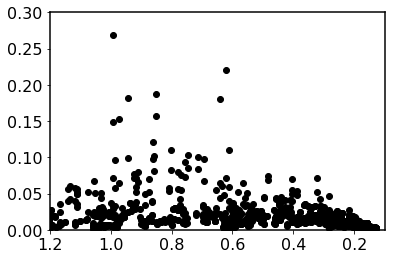

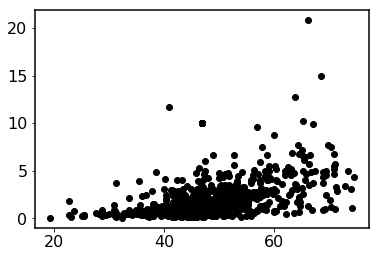

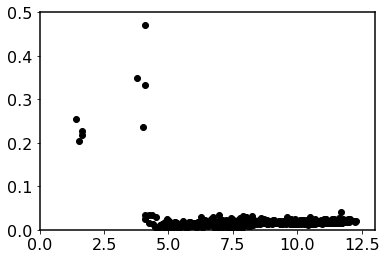

In [15]:
def hyades_mass_unc():
    #mK,mK_err,dist,dist_err
    
    mK = np.copy(hdat["TWOMASS_K"])
    e_mK = np.copy(hdat["TWOMASS_KERR"])

    dist = hdat["DISTANCE"] #pc
    e_dist = hdat["DISTANCE_ERR"] #pc
    
    mass,mass_errs = calc_mass_unc(mK, e_mK, dist, e_dist)
    
    good_mass = np.where(mass>0)[0]
    good_errs = np.zeros(2*len(good_mass)).reshape((2,-1))
    good_errs[0] = mass_errs[0][good_mass]
    good_errs[1] = mass_errs[1][good_mass]

    
    plt.plot(mass[good_mass], good_errs[0],'ko')
    plt.plot(mass[good_mass], good_errs[1],'ko')
    plt.xlim(1.2,0.1)
    plt.ylim(0,0.3)
    
    plt.figure()
    plt.plot(dist,e_dist,'ko')
    plt.figure()
    plt.plot(mK,e_mK,'ko')
    plt.xlim(0,13)
    plt.ylim(0,0.5)
    
    return mass, mass_errs

mass, mass_errs = hyades_mass_unc()
good_mass = np.where(mass>0)[0]
mass_errs2 = (mass_errs[0]+mass_errs[1])/2.0
print(np.median(mass_errs2[good_mass]/mass[good_mass]))

In [18]:
gaia_tab["GAIA_QUAL"]

True
--
True
--
True
True
True
True
True
True
--


In [33]:
pmass = np.copy(pmass0)
greplace = np.where((gaia_tab['KH_MASS_GAIA']>0) & 
                    (gaia_tab["GAIA_QUAL"]=="True") & 
                    (gaia_tab["GAIA_QUAL"].mask==False))[0]

pmass[gaia_tab["HYADES_IDX"][greplace]] = gaia_tab["KH_MASS_GAIA"][greplace]

mass_errs[0][gaia_tab["HYADES_IDX"][greplace]] = gaia_tab["e_KH_MASS_GAIA0"][greplace]
mass_errs[1][gaia_tab["HYADES_IDX"][greplace]] = gaia_tab["e_KH_MASS_GAIA1"][greplace]

mass_errs2[gaia_tab["HYADES_IDX"][greplace]] = gaia_tab["e_KH_MASS_GAIA"][greplace]

print(len(pmass),len(mass_errs2))

786 786


In [34]:
print(np.unique(pflag))

['-' '2' '3' 'D' 'H' 'K' 'P' 'R']


In [35]:
# Read in Kraus & Hillenbrand for later use
kh = at.read(os.path.expanduser('~/HyPra/models/kraushillenbrand5.dat'))
ksub = np.array([-20,-19,-15,-12,-11,-9,-7,-6])#,-5,-4,-3,-2,-1])
ksub = np.arange(-22,-5,2)
kh_mass = kh["Mass"][ksub]
kh_spt = kh['SpT'][ksub]

def add_spt_pm(ax):
    ymax = ax.get_ylim()[1]
    for khm,khs in zip(kh_mass,kh_spt):
        ax.text(khm,ymax*1.01,khs,verticalalignment="bottom",horizontalalignment="center",
               fontsize="x-large")
    ax.xaxis.set_ticks_position('bottom')

In [36]:
def plot_period_vs_x(xx=pmass, xerrs=mass_errs2,ax=None, plot_binaries=True, mark_binaries=True, sources=True, 
                     logmass=False, mass_unc=False, color_sources="papers",
                     which_sources=['H', 'P', 'R', 'D', 'K', '2', '3'],qual=0,min_pmem=70,max_bad=0,
                     textx=1.25,print_sources=True):
    
    good_quality = (pqual>=0) & (pqual<=qual) & (pbad<=max_bad)
    
    #color1 = plt.cm.inferno(0.5)
    #color2 = plt.cm.inferno(0.75)
    
    #cmap = plt.cm.viridis
    
    old_color = "k"
    max_bad = 0

    if color_sources=="papers":
        # TODO: FIX THESE TO MATCH OTHER PLOTS
        pcolors = {"D": cmap_qual[2],
                   "K": cmap_qual[4],
                   "R": cmap_qual[5],
                   "P": cmap_qual[0],
                   "H": cmap_qual[6],
                   "2": cmap_qual[3],
                   "3": k2_color
                  }

    elif color_sources=="old":
#         pcolors = {"D": 'DarkGrey', "K": 'DarkGrey', "S": 'DarkGrey',
#                    "2": "Red", "P": 'DarkGrey', "H": 'DarkGrey'}
        old_color = plt.cm.Greys(0.4)#"#cccccc" #"DarkGrey"
        pcolors = {"H": old_color,
                   "P": old_color,
                   "R": old_color,
                   "D": old_color,
                   "K": old_color,
                   "2": old_color,
                   "3": k2_color
                  }
    elif color_sources=="background":
        old_color = plt.cm.Greys(0.4)#"#cccccc" #"DarkGrey"
        pcolors = {"H": old_color,
                   "P": old_color,
                   "R": old_color,
                   "D": old_color,
                   "K": old_color,
                   "2": old_color,
                   "3": old_color,
                  }
    plabels = {"D": 'Delorme+ 2011', "K": 'ASAS (D14)', "R": 'Radick+ 1987,1995',
               "2": "K2 C4 (D16)", "P": 'Prosser+ 1995', "H": 'Hartman+2011',
              "3": "K2 C13 (This Work)"}
    
    if "3" in which_sources:
        plotbink2 = True
    else:
        plotbink2 = False
        
    ms_off = 1.5

    
    if ax is None:
        fig = plt.figure(figsize=single_figure)
        ax = plt.subplot(111)
        

    ax.plot([],[],'D', ms=std_ms-ms_off, mew=std_mew,mec='k',mfc='k',label=r"Hyades")# (P$_{mem}$>%.0f%%, Quality<=%i)" % (min_pmem, qual))
    if plot_binaries==True:
        # Binaries included
        
        if (sources==False) & (mass_unc==True):
            bin_loc = np.where(good_quality & ((hdat["BINARY"]>=1) | (pblend>0)))[0]
            sub_errs = np.zeros(2*len(bin_loc)).reshape((2,-1))
            sub_errs[0] = xerrs[0][bin_loc]
            sub_errs[1] = xerrs[1][bin_loc]
            ax.errorbar(xx[bin_loc],pperiods[bin_loc],xerr=sub_errs,linestyle="None",
                        color="k",ecolor="k",zorder=-111,elinewidth=1.5,mew=1.5)
        elif (sources==True) & (mass_unc==True):
            for k in which_sources:
                bin_loc = np.where(good_quality & ((hdat["BINARY"]>=1) | (pblend>0)) & (pflag==k))[0]
                sub_errs = np.zeros(2*len(bin_loc)).reshape((2,-1))
                sub_errs[0] = xerrs[0][bin_loc]
                sub_errs[1] = xerrs[1][bin_loc]
                ax.errorbar(xx[bin_loc],pperiods[bin_loc],xerr=sub_errs,linestyle="None",
                            color=pcolors[k],ecolor=pcolors[k],zorder=-111,elinewidth=1.5,mew=1.5)
    
            
        if (sources==True) & (mark_binaries==True):
            for k in which_sources:
                ax.plot(xx[(pflag==k) & (hdat["BINARY"]==1) & good_quality],
                        pperiods[(pflag==k) & (hdat["BINARY"]==1) & good_quality],
                        'D',mec=pcolors[k],mfc='None', ms=std_ms-ms_off, mew=std_mew)

                ax.plot(xx[(pflag==k) & (hdat["BINARY"]>=2) & good_quality],
                        pperiods[(pflag==k) & (hdat["BINARY"]>=2) & good_quality],
                        '+',mec=pcolors[k],mfc='None', ms=std_ms, mew=std_mew)
                
                ax.plot(xx[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                        pperiods[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                        's',mec=pcolors[k],mfc='None',ms=std_ms, mew=std_mew) #'s'
                
        elif (sources==True) & (mark_binaries==False):
            for k in which_sources:
                ax.plot(xx[(pflag==k) & ((hdat["BINARY"]>=1) | (pblend>0)) & good_quality],
                        pperiods[(pflag==k) & ((hdat["BINARY"]>=1) | (pblend>0)) & good_quality],
                        'D',mec=pcolors[k],mfc=pcolors[k], ms=std_ms-ms_off, mew=std_mew)
        else:
            ax.plot(xx[(pperiods>0) & (hdat["BINARY"]==1) & good_quality],
                    pperiods[(pperiods>0) & (hdat["BINARY"]==1) & good_quality],
                    'D',mec='k',mfc='None', ms=std_ms-ms_off, mew=std_mew)
            ax.plot(xx[(pperiods>0) & (hdat["BINARY"]>=2) & good_quality],
                    pperiods[(pperiods>0) & (hdat["BINARY"]>=2) & good_quality],
                    '+',mec='k', ms=std_ms, mew=std_mew)
            ax.plot(xx[(pperiods>0) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                    pperiods[(pperiods>0) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                    's',mec='k',mfc='None', ms=std_ms, mew=std_mew)#'s'
            
        if mark_binaries==True:
            ax.plot([],[],'D', ms=std_ms-ms_off, mew=std_mew,mec='k',mfc='None',label="Candidate Binary")
            ax.plot([],[],'+', ms=std_ms, mew=std_mew,mec='k',mfc='None',label="Confirmed Binary")
            ax.plot([],[],'s', ms=std_ms, mew=std_mew,mec='k',mfc='None',label="Blend / Multiperiod")

    # Binaries excluded
    if sources==True:
        
        for k in which_sources:
            if mass_unc==True:
                bin_loc = np.where((hdat["BINARY"]==0) & (pflag==k) & good_quality
                                   & (pblend==0))[0]
                sub_errs = np.zeros(2*len(bin_loc)).reshape((2,-1))
                sub_errs[0] = xerrs[0][bin_loc]
                sub_errs[1] = xerrs[1][bin_loc]
                ax.errorbar(xx[bin_loc],pperiods[bin_loc],xerr=sub_errs,linestyle="None",
                            color=pcolors[k],ecolor=pcolors[k],zorder=-111,elinewidth=1.5,mew=1.5)

            ax.plot(xx[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==0)],
                    pperiods[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==0)],
                    'D',mec=pcolors[k],mfc=pcolors[k], ms=std_ms-ms_off, mew=std_mew)
            
            if (k=="2") and (plotbink2 is True):
                ax.plot(xx[(pflag==k) & (hdat["BINARY"]==1) & good_quality],
                        pperiods[(pflag==k) & (hdat["BINARY"]==1) & good_quality],
                        'D',mec=pcolors[k],mfc='None', ms=std_ms-ms_off, mew=std_mew)

                ax.plot(xx[(pflag==k) & (hdat["BINARY"]>=2) & good_quality],
                        pperiods[(pflag==k) & (hdat["BINARY"]>=2) & good_quality],
                        '+',mec=pcolors[k],mfc='None', ms=std_ms, mew=std_mew)                

                ax.plot(xx[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                        pperiods[(pflag==k) & (hdat["BINARY"]==0) & good_quality & (pblend==1)],
                        's',mec=pcolors[k],mfc='None', ms=std_ms, mew=std_mew)                #'s'

        if logmass==True:
            texty = np.logspace(np.log10(0.15),np.log10(0.8),num=9)
            textx = 0.94
        else:
            texty = np.logspace(np.log10(0.12),np.log10(0.8),num=9)
            
        ycount = 7
        textsize = 14
        if (color_sources=="papers") and (print_sources is True):
            ax.text(textx,texty[8],'Periods from',color='k',fontsize=textsize)
            for k in which_sources:
                print(textx, texty[ycount])
                ax.text(textx,texty[ycount], plabels[k], color=pcolors[k], fontsize=textsize)
                ycount -= 1
        elif (color_sources=="old") and (("2" in which_sources)==True)  and (print_sources is True):
            ax.text(textx,texty[8],'Periods from',color='k',fontsize=textsize)
            ax.text(textx,texty[7], plabels["3"], color=pcolors["3"], fontsize=textsize)
#            ax.text(textx,texty[4], "Previous Studies", color="DarkGrey", fontsize='xx-large')
            ycount = 6
            for k in ['H', 'P', 'R', 'D', 'K', "2"]:
                print(textx, texty[ycount])
                ax.text(textx,texty[ycount], plabels[k], color=plt.cm.Greys(0.5), 
                        fontsize=textsize)
                ycount -= 1
                
    else:
        single_loc = ((pperiods>0) & (hdat["BINARY"]==0) & good_quality & (pblend==0))
        if mass_unc is True:
            sub_errs = np.zeros(2*len(np.where(single_loc)[0])).reshape((2,-1))
            sub_errs[0] = xerrs[0][single_loc]
            sub_errs[1] = xerrs[1][single_loc]
            ax.errorbar(xx[single_loc],pperiods[single_loc],xerr=sub_errs,linestyle="None",
                        color="k",ecolor="k",zorder=-111,elinewidth=1.5,mew=1.5)
        ax.plot(xx[single_loc],pperiods[single_loc],
                'D',mec='k',mfc='k', ms=std_ms-ms_off, mew=std_mew)

    ax.legend(loc=2,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize=14)

    return ax

    
def plot_period_mass(ax=None, plot_binaries=True, mark_binaries=True, sources=True, 
                     logmass=False, mass_unc=False, color_sources="papers",
                     which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0,
                     textx=1.25,print_sources=True):
    
    ax = plot_period_vs_x(xx=pmass, xerrs=mass_errs, ax=ax, plot_binaries=plot_binaries,
                          mark_binaries=mark_binaries, sources=sources, 
                         logmass=logmass, mass_unc=mass_unc, color_sources=color_sources,
                         which_sources=which_sources,qual=qual,min_pmem=min_pmem,
                         textx=textx,max_bad=max_bad,print_sources=print_sources)

    ax.set_ylim(0.1,50)
    ax.set_yscale('log')
    ax.set_xlabel(r'Mass ($M_{\odot}$)',fontsize=20)
    ax.set_ylabel('Period (d)',fontsize=20)
    ax.tick_params(labelsize=20,width=2, length=8)
    ax.tick_params(which="minor",width=2, length=4)
    ax.set_yticklabels(["","0.1","1","10"])

    if logmass==True:
        ax.set_xscale("log")
        ax.set_xlim(1,0.1)
        ax.xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(["","0.1","1"]))
        ax.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter("%0.1f"))
        ax.tick_params(which="minor",labelsize=12)

    else:
        ax.set_xlim(1.3,0.1)
        ax.set_xticks(np.arange(0.1,1.4,0.1),minor=True)
    

    ## K2 thruster firing harmonics
    #for harm in np.append(0.25,np.arange(0.5,1.6,0.6)):
    #    ax.axhline(harm,color='LightGrey',ls="--")

1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888
1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888


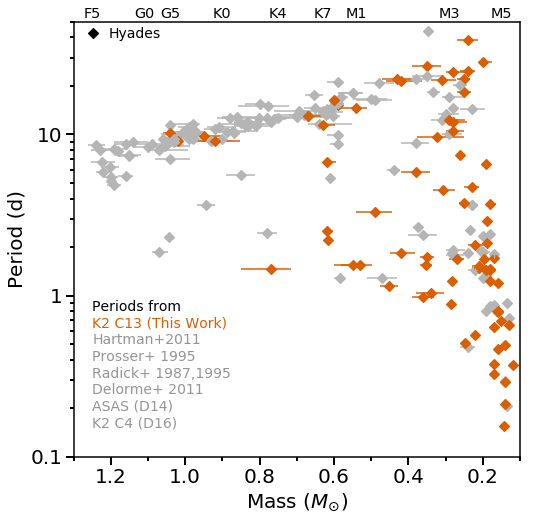

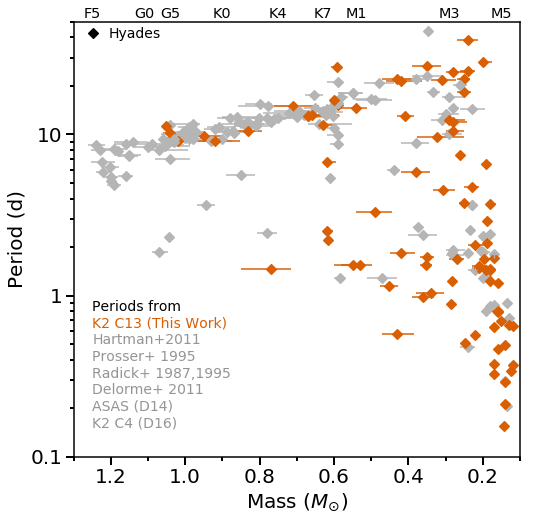

In [37]:
fig = plt.figure(figsize=single_figure)
ax = plt.subplot(111)
plot_period_mass(ax=ax, plot_binaries=True, sources=True, logmass=False,
                 color_sources="old", mark_binaries=False,
                 mass_unc=True, qual=0,min_pmem=70,max_bad=0)
add_spt_pm(ax=ax)

#ax.tick_params(labelsize="xx-large")
#ax.legend_.remove()
#ax.legend(loc=2,numpoints=1,handletextpad=0.1,borderaxespad=0.15,frameon=False,fontsize=14)

plt.savefig("periodmass_hyades_c13_nobinaries.png",bbox_inches="tight",
           dpi=600)

fig = plt.figure(figsize=single_figure)
ax = plt.subplot(111)
plot_period_mass(ax=ax, plot_binaries=True, sources=True, logmass=False,
                 color_sources="old", mark_binaries=False,
                 mass_unc=True, qual=1,min_pmem=70,max_bad=0)
add_spt_pm(ax=ax)

#ax.tick_params(labelsize="xx-large")
#ax.legend_.remove()
#ax.legend(loc=2,numpoints=1,handletextpad=0.1,borderaxespad=0.15,frameon=False,fontsize=14)

plt.savefig("periodmass_hyades_c13_nobinaries_lowqual.png",bbox_inches="tight",
           dpi=600)

1.25 0.6311046707675568
1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643


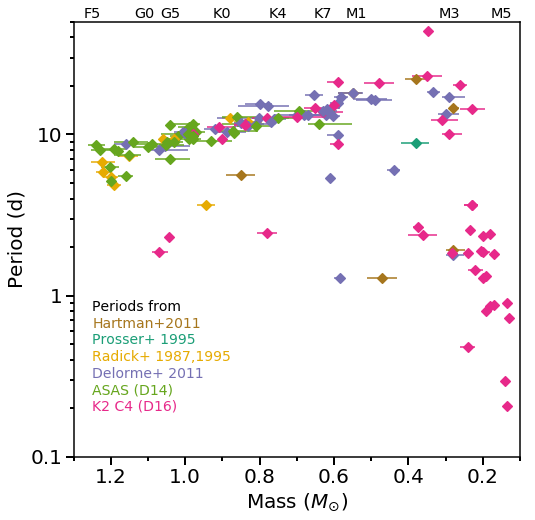

In [38]:
plot_period_mass(ax=None,  plot_binaries=True, mark_binaries=False, 
                sources=True, which_sources=['H','P','R','D','K','2'], 
                 color_sources="papers", mass_unc=True)
ax = plt.gca()
add_spt_pm(ax=ax)
ax.legend_.remove()


plt.savefig(os.path.expanduser("~/my_papers/hyadesk22/periodmass_oldcolor.eps"),
            bbox_inches="tight")

1.25 0.6311046707675568
1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888


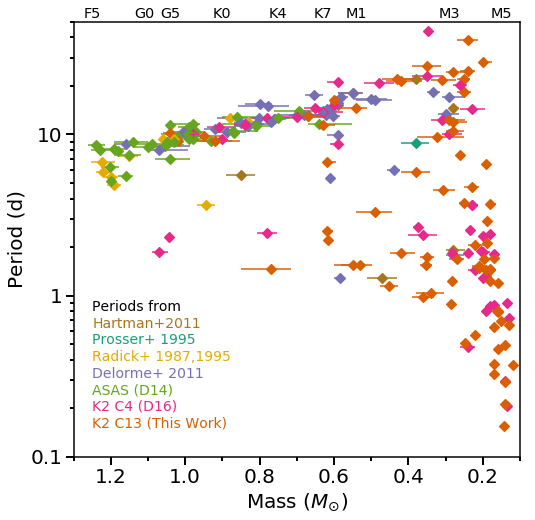

In [39]:
plot_period_mass(ax=None,  plot_binaries=True, mark_binaries=False, 
                sources=True, which_sources=['H','P','R','D','K','2','3'], 
                 color_sources="papers", mass_unc=True)
ax = plt.gca()
add_spt_pm(ax=ax)
ax.legend_.remove()

# # plt.savefig("/home/stephanie/Dropbox/plots_for_sharing/praesepe_periodmass_oldcolor.png", bbox_inches="tight")
# # plt.savefig("../k2_plots/periodmass_oldcolor.png", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/periodmass_oldcolor.png", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig1.eps", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig1.pdf", bbox_inches="tight")

1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888
1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888


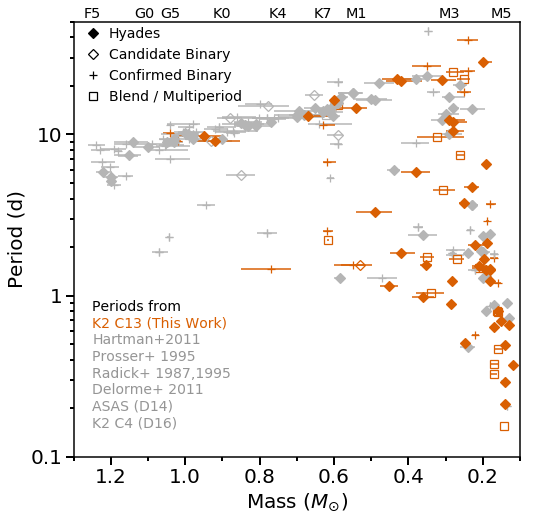

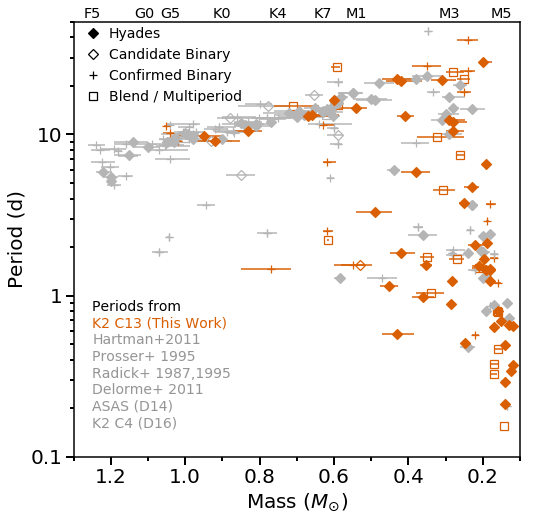

In [40]:
plot_period_mass(ax=None, plot_binaries=True, sources=True, 
                 which_sources=['H','P','R','D','K','2','3'], 
                 color_sources="old", mass_unc=True)
ax = plt.gca()
add_spt_pm(ax=ax)

plt.savefig(os.path.expanduser("~/my_papers/hyadesk22/periodmass_hyades_newk2.eps"),
            bbox_inches="tight")
# plt.savefig("../k2_plots/periodmass_old.png", bbox_inches="tight")

plot_period_mass(ax=None, plot_binaries=True, sources=True, 
                 which_sources=['H','P','R','D','K','2','3'], 
                 color_sources="old", mass_unc=True, qual=1)
ax = plt.gca()
add_spt_pm(ax=ax)

plt.savefig(os.path.expanduser("~/my_papers/hyadesk22/periodmass_hyades_newk2_lowqual.eps"),
            bbox_inches="tight")
# plt.savefig("../k2_plots/periodmass_old.png", bbox_inches="tight")

1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888
1.25 0.49786638183078274
1.25 0.39275724873943846
1.25 0.30983866769659335
1.25 0.2444257879596462
1.25 0.19282282054671643
1.25 0.15211422834700888


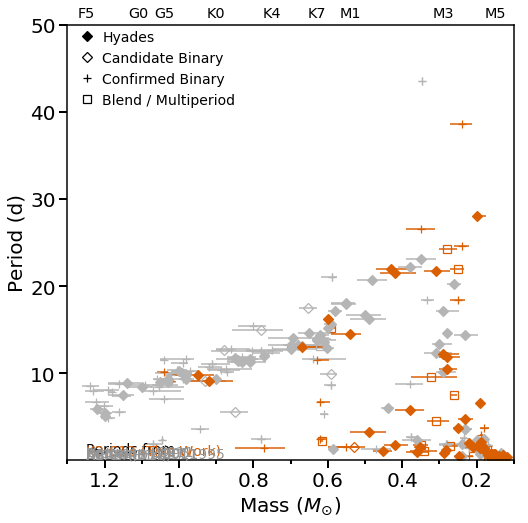

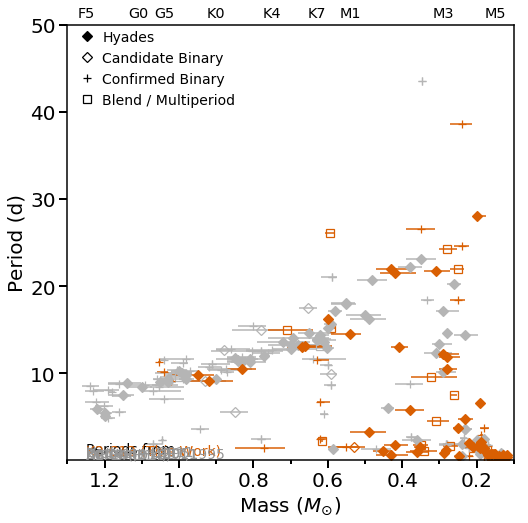

In [55]:
plot_period_mass(ax=None, plot_binaries=True, sources=True, 
                 which_sources=['H','P','R','D','K','2','3'], 
                 color_sources="old", mass_unc=True)
ax = plt.gca()
add_spt_pm(ax=ax)
ax.set_yscale("linear")

plt.savefig(os.path.expanduser("~/my_papers/hyadesk22/periodmass_hyades_newk2_linearProt.eps"),
            bbox_inches="tight")
# plt.savefig("../k2_plots/periodmass_old.png", bbox_inches="tight")

plot_period_mass(ax=None, plot_binaries=True, sources=True, 
                 which_sources=['H','P','R','D','K','2','3'], 
                 color_sources="old", mass_unc=True, qual=1)
ax = plt.gca()
add_spt_pm(ax=ax)
ax.set_yscale("linear")

plt.savefig(os.path.expanduser("~/my_papers/hyadesk22/periodmass_hyades_newk2_lowqual_linearProt.eps"),
            bbox_inches="tight")
# plt.savefig("../k2_plots/periodmass_old.png", bbox_inches="tight")

# Compare to Matt+2015 models

In [41]:
matt650 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_00653Myr.txt"))
matt650_mass = matt650["col1"][:1000]
matt650_period = matt650["col2"][:1000]
matt575 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_00574Myr.txt"))
matt575_mass = matt575["col1"][:500]
matt575_period = matt575["col2"][:500]
matt750 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_00742Myr.txt"))
matt750_mass = matt750["col1"][:500]
matt750_period = matt750["col2"][:500]
matt850 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_00837Myr.txt"))
matt850_mass = matt850["col1"][:500]
matt850_period = matt850["col2"][:500]
matt1050 = at.read(os.path.expanduser("~/HyPra/models/Mattea2015_01058Myr.txt"))
matt1050_mass = matt1050["col1"][:500]
matt1050_period = matt1050["col2"][:500]

In [42]:
color_idx = np.linspace(0,1,6)

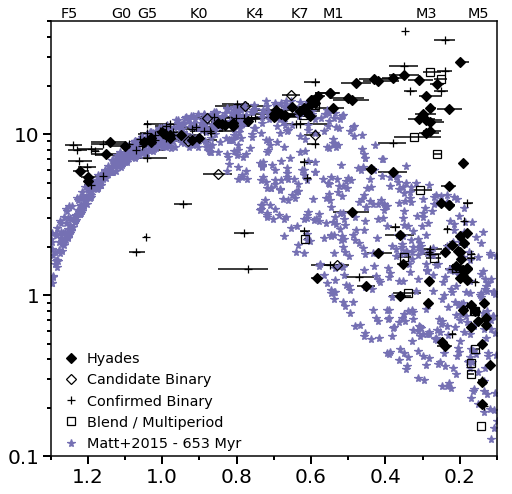

In [43]:
fig = plt.figure(figsize=single_figure)
ax2 = plt.subplot(111)
plot_period_mass(ax=ax2, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax2.legend_.remove()
model_color = cmap(color_idx[2]) 

ax2.plot(matt650_mass,matt650_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 653 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax2.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax2.set_ylabel("")
ax2.set_xlabel("")
add_spt_pm(ax=ax2)

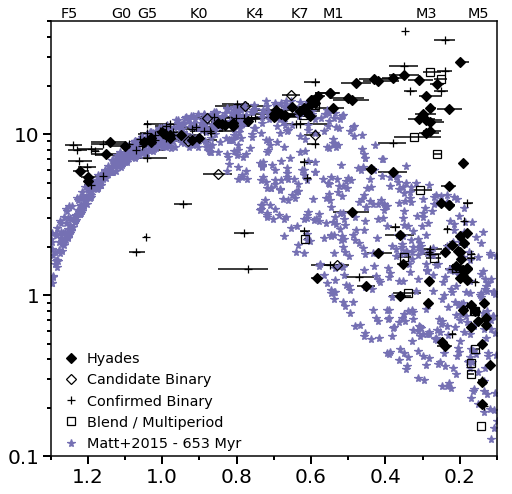

In [44]:
fig = plt.figure(figsize=single_figure)
ax2 = plt.subplot(111)
plot_period_mass(ax=ax2, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax2.legend_.remove()
model_color = cmap(color_idx[2]) 
ax2.plot(matt650_mass,matt650_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 653 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax2.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax2.set_ylabel("")
ax2.set_xlabel("")
add_spt_pm(ax=ax2)

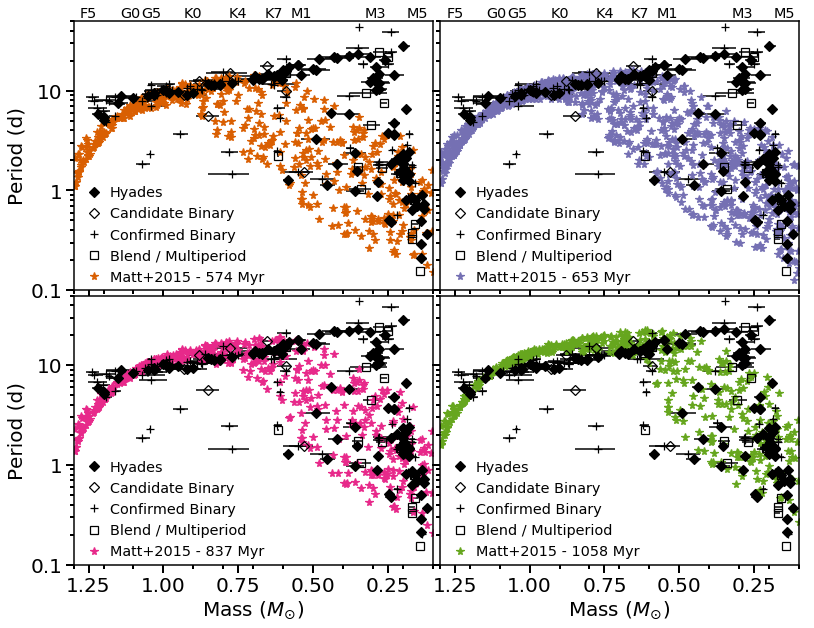

In [45]:
fig = plt.figure(figsize=quad_square)

ax1 = plt.subplot(221)
plot_period_mass(ax=ax1, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax1.legend_.remove()
model_color = cmap(color_idx[1])
ax1.plot(matt575_mass,matt575_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 574 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax1.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax1.set_xlabel("")
add_spt_pm(ax=ax1)
ax1.tick_params(labelbottom=False)

ax2 = plt.subplot(222,sharex=ax1,sharey=ax1)
plot_period_mass(ax=ax2, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax2.legend_.remove()
model_color = cmap(color_idx[2]) 
ax2.plot(matt650_mass,matt650_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 653 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax2.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax2.set_ylabel("")
ax2.set_xlabel("")
add_spt_pm(ax=ax2)
ax2.tick_params(labelbottom=False,labelleft=False)

ax3 = plt.subplot(223,sharex=ax1,sharey=ax1)
plot_period_mass(ax=ax3, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax3.legend_.remove()
model_color = cmap(color_idx[3]) 
# ax3.plot(matt750_mass,matt750_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 742 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax3.plot(matt850_mass,matt850_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 837 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax3.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")

ax4 = plt.subplot(224,sharex=ax1,sharey=ax1)
plot_period_mass(ax=ax4, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)
ax4.legend_.remove()
model_color = cmap(color_idx[4]) 
# ax4.plot(matt850_mass,matt850_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 837 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax4.plot(matt1050_mass,matt1050_period,"*",mec=model_color,mfc=model_color,label="Matt+2015 - 1058 Myr",ms=std_ms,mew=std_mew,zorder=-1)
ax4.legend(loc=3,numpoints=1,handletextpad=0.1,borderaxespad=0,frameon=False,fontsize="x-large")
ax4.set_ylabel("")
ax4.tick_params(labelleft=False)

plt.subplots_adjust(hspace=0.02,wspace=0.02)
# plt.savefig("/home/stephanie/Dropbox/talks/hypra figs/praesepe_compmatt_k2sc_withbinaries_four.png", bbox_inches="tight", dpi=300)
# plt.savefig("../k2_plots/praesepe_compmatt_k2sc_withbinaries_four.png", bbox_inches="tight", dpi=300)

# Compare to literature periods

K2+lit: 23
H With two measurements: 1 Significantly different: 0
P With two measurements: 1 Significantly different: 1
R With two measurements: 2 Significantly different: 1
D With two measurements: 9 Significantly different: 2
K With two measurements: 5 Significantly different: 2
2 With two measurements: 5 Significantly different: 0


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


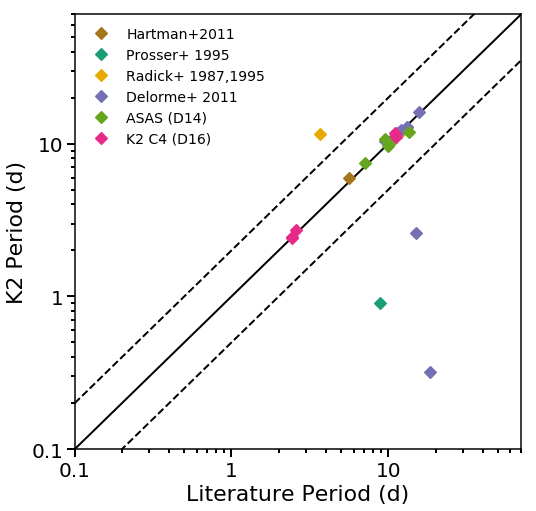

In [46]:
pcolors = {"D": cmap_qual[2],
           "K": cmap_qual[4],
           "R": cmap_qual[5],
           "P": cmap_qual[0],
           "H": cmap_qual[6],
           "2": cmap_qual[3],
           "3": k2_color}
plabels = {"D": 'Delorme+ 2011', "K": 'ASAS (D14)', "R": 'Radick+ 1987,1995',
           "2": "K2 C4 (D16)", "P": 'Prosser+ 1995', "H": 'Hartman+2011',
          "3": "K2 C13 (This Work)"}
    

comparison_set = (hdat["PERIOD"]>0.01) & (pperiods_onlyk2>0.01) & ((pqual==0) | (pqual==1))
print("K2+lit:",len(np.where(comparison_set)[0]))
plt.figure(figsize=single_figure)
ax = plt.subplot(111)

x = np.linspace(0.1,99,100)
ax.plot(x,x,'k-',lw=2) 
ax.plot(x,x*2,'k--',lw=2)
ax.plot(x,x/2,'k--',lw=2)

# ax.plot(1/(1.0/x + 1.0),x,'k-.',lw=2)
# ax.plot(x,1/(1.0/x + 1.0/3.0),'k-.')
# for p in np.arange(2,10):
#     ax.plot(1/(1.0/x + 1./p),x,'k-.')
#     ax.plot(x,1/(1.0/x + 1./p),'k-.') # This math might be wrong?
# ax.plot(1/(1/x + 1/29.5),x,'k-.')

diff_set = np.array([])
diff_k2 = np.array([])
diff_lit = np.array([])
for s in ['H','P','R','D','K','2']:
    qual = (pflag==s) & comparison_set
    diff_k2 = np.append(diff_k2,pperiods_onlyk2[qual])
    diff_lit = np.append(diff_lit,pperiods[qual])
    qepic = hdat["EPIC_ID"][qual]
    # Check for significant discrepancies
    diff = abs(pperiods[qual]-pperiods_allk2[qual])/pperiods_allk2[qual]
    sig_diff = np.where(diff>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff])
    diff_sec = abs(pperiods[qual]-pperiods_secondary[qual])/pperiods_secondary[qual]
    sig_diff_sec = np.where(diff_sec>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff_sec])
    print(s,"With two measurements:",len(np.where(qual)[0]),
          "Significantly different:",len(sig_diff))
#     print(qepic[sig_diff])
#     print(pperiods[qual][sig_diff])
#     print(pperiods_onlyk2[qual][sig_diff])
#     ax.plot(pperiods[qual],pperiods_allc5[qual],'o',mfc="none",mec=pcolors[s],
#             mew=std_mew,ms=std_ms)
#     ax.plot(pperiods[qual & (pblend==0)],pperiods_allc5[qual & (pblend==0)],'o',
#             mfc=pcolors[s],mec=pcolors[s],label=plabels[s],ms=std_ms,mew=std_mew)
    ax.plot(pperiods[qual],pperiods_allk2[qual],'D',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc=pcolors[s],label=plabels[s])
ax.set_xlabel("Literature Period (d)",fontsize=22)
ax.set_ylabel("K2 Period (d)",fontsize=22)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.1,70)
ax.set_ylim(0.1,70)
ax.tick_params(labelsize=20,width=2, length=8)
ax.tick_params(which="minor",width=2, length=4)
ax.set_yticklabels(["","0.1","1","10"])
ax.set_xticklabels(["","0.1","1","10"])
ax.legend(loc=2,frameon=False, numpoints=1)
plt.savefig(os.path.expanduser("~/my_papers/hyadesk22/compare_lit_color.eps"),
                               bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig8.eps", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig8.pdf", bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/compare_lit_k2sc_litcolor.png", bbox_inches="tight")

H With two measurements: 1 Significantly different: 0
[]
[]
[]
P With two measurements: 1 Significantly different: 1
[210558541]
[8.8]
[0.9041]
R With two measurements: 2 Significantly different: 1
[210554781]
[3.66]
[11.5143]
D With two measurements: 9 Significantly different: 2
[246806983 246714118]
[14.94 18.41]
[2.6103 0.3216]
['1SWASPJ051109.69+154857.5' '1SWASPJ043033.88+144453.1']
K With two measurements: 5 Significantly different: 2
[210666330 247369717]
[ 9.551653 13.589424]
[10.6945 11.8317]
2 With two measurements: 5 Significantly different: 0
[]
[]
[]


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


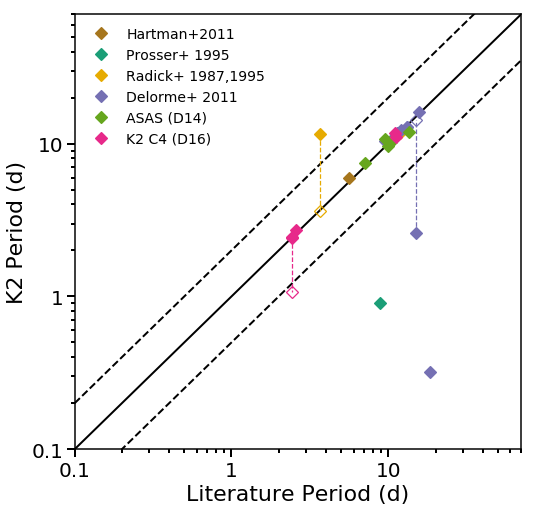

In [47]:

plt.figure(figsize=single_figure)
ax = plt.subplot(111)

x = np.linspace(0.1,99,100)
ax.plot(x,x,'k-',lw=2) 
ax.plot(x,x*2,'k--',lw=2)
ax.plot(x,x/2,'k--',lw=2)

# ax.plot(1/(1.0/x + 1.0),x,'k-.',lw=2)
# ax.plot(x,1/(1.0/x + 1.0/3.0),'k-.')
# for p in np.arange(2,10):
#     ax.plot(1/(1.0/x + 1./p),x,'k-.')
#     ax.plot(x,1/(1.0/x + 1./p),'k-.') # This math might be wrong?
# ax.plot(1/(1/x + 1/29.5),x,'k-.')

diff_set = np.array([])
diff_k2 = np.array([])
diff_lit = np.array([])
for s in ['H','P','R','D','K','2']:
    qual = (pflag==s) & comparison_set
    diff_k2 = np.append(diff_k2,pperiods_onlyk2[qual])
    diff_lit = np.append(diff_lit,pperiods[qual])
    qepic = hdat["EPIC_ID"][qual]
    # Check for significant discrepancies
    diff = abs(pperiods[qual]-pperiods_allk2[qual])/pperiods_allk2[qual]
    sig_diff = np.where(diff>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff])
    # And for secondary periods
    diff_sec = abs(pperiods[qual]-pperiods_secondary[qual])/pperiods_secondary[qual]
    sig_diff_sec = np.where(diff_sec>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff_sec])
    print(s,"With two measurements:",len(np.where(qual)[0]),
          "Significantly different:",len(sig_diff))
    print(qepic[sig_diff])
    print(pperiods[qual][sig_diff])
    print(pperiods_onlyk2[qual][sig_diff])
    if s=="D":
        print(hdat["SWASP_ID"][qual][sig_diff])
#     ax.plot(pperiods[qual],pperiods_allc5[qual],'o',mfc="none",mec=pcolors[s],
#             mew=std_mew,ms=std_ms)
#     ax.plot(pperiods[qual & (pblend==0)],pperiods_allc5[qual & (pblend==0)],'o',
#             mfc=pcolors[s],mec=pcolors[s],label=plabels[s],ms=std_ms,mew=std_mew)
    ax.plot(pperiods[qual],pperiods_allk2[qual],'D',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc=pcolors[s],label=plabels[s])
    ax.plot(pperiods[qual],pperiods_secondary[qual],'D',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc="none")
    for i in np.where(qual)[0]:
        if (pperiods_allk2[i]>0) and (pperiods_secondary[i]>0):
            ax.plot([pperiods[i],pperiods[i]],[pperiods_allk2[i],pperiods_secondary[i]],
                   "--",lw=std_mew,color=pcolors[s])
ax.set_xlabel("Literature Period (d)",fontsize=22)
ax.set_ylabel("K2 Period (d)",fontsize=22)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.1,70)
ax.set_ylim(0.1,70)
ax.tick_params(labelsize=20,width=2, length=8)
ax.tick_params(which="minor",width=2, length=4)
ax.set_yticklabels(["","0.1","1","10"])
ax.set_xticklabels(["","0.1","1","10"])
ax.legend(loc=2,frameon=False, numpoints=1)

H With two measurements: 1 Significantly different: 0
[]
[]
[]
P With two measurements: 1 Significantly different: 1
[210558541]
[8.8]
[0.9041]
R With two measurements: 2 Significantly different: 1
[210554781]
[3.66]
[11.5143]
D With two measurements: 9 Significantly different: 2
[246806983 246714118]
[14.94 18.41]
[2.6103 0.3216]
['1SWASPJ051109.69+154857.5' '1SWASPJ043033.88+144453.1']
K With two measurements: 5 Significantly different: 2
[210666330 247369717]
[ 9.551653 13.589424]
[10.6945 11.8317]
2 With two measurements: 5 Significantly different: 0
[]
[]
[]


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


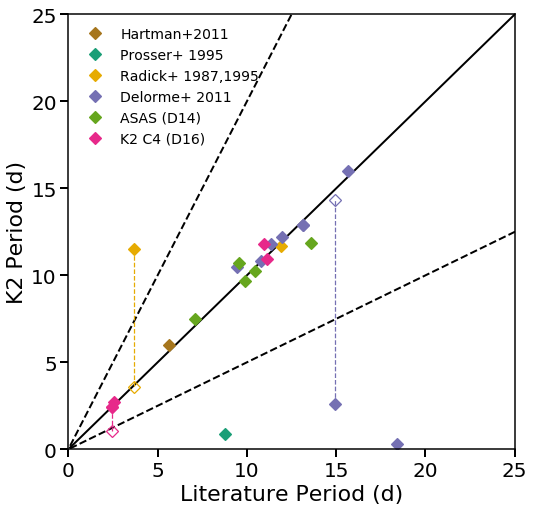

In [48]:

plt.figure(figsize=single_figure)
ax = plt.subplot(111)

x = np.linspace(0.1,99,100)
ax.plot(x,x,'k-',lw=2) 
ax.plot(x,x*2,'k--',lw=2)
ax.plot(x,x/2,'k--',lw=2)

# ax.plot(1/(1.0/x + 1.0),x,'k-.',lw=2)
# ax.plot(x,1/(1.0/x + 1.0/3.0),'k-.')
# for p in np.arange(2,10):
#     ax.plot(1/(1.0/x + 1./p),x,'k-.')
#     ax.plot(x,1/(1.0/x + 1./p),'k-.') # This math might be wrong?
# ax.plot(1/(1/x + 1/29.5),x,'k-.')

diff_set = np.array([])
diff_k2 = np.array([])
diff_lit = np.array([])
for s in ['H','P','R','D','K','2']:
    qual = (pflag==s) & comparison_set
    diff_k2 = np.append(diff_k2,pperiods_onlyk2[qual])
    diff_lit = np.append(diff_lit,pperiods[qual])
    qepic = hdat["EPIC_ID"][qual]
    # Check for significant discrepancies
    diff = abs(pperiods[qual]-pperiods_allk2[qual])/pperiods_allk2[qual]
    sig_diff = np.where(diff>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff])
    # And for secondary periods
    diff_sec = abs(pperiods[qual]-pperiods_secondary[qual])/pperiods_secondary[qual]
    sig_diff_sec = np.where(diff_sec>0.1)[0]
    diff_set = np.append(diff_set, np.where(qual)[0][sig_diff_sec])
    print(s,"With two measurements:",len(np.where(qual)[0]),
          "Significantly different:",len(sig_diff))
    print(qepic[sig_diff])
    print(pperiods[qual][sig_diff])
    print(pperiods_onlyk2[qual][sig_diff])
    if s=="D":
        print(hdat["SWASP_ID"][qual][sig_diff])
#     ax.plot(pperiods[qual],pperiods_allc5[qual],'o',mfc="none",mec=pcolors[s],
#             mew=std_mew,ms=std_ms)
#     ax.plot(pperiods[qual & (pblend==0)],pperiods_allc5[qual & (pblend==0)],'o',
#             mfc=pcolors[s],mec=pcolors[s],label=plabels[s],ms=std_ms,mew=std_mew)
    ax.plot(pperiods[qual],pperiods_allk2[qual],'D',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc=pcolors[s],label=plabels[s])
    ax.plot(pperiods[qual & (pperiods_secondary>0)],
            pperiods_secondary[qual& (pperiods_secondary>0)],'D',mec=pcolors[s],
            mew=std_mew,ms=std_ms,mfc="none")
    for i in np.where(qual)[0]:
        if (pperiods_allk2[i]>0) and (pperiods_secondary[i]>0):
            ax.plot([pperiods[i],pperiods[i]],[pperiods_allk2[i],pperiods_secondary[i]],
                   "--",lw=std_mew,color=pcolors[s])
ax.set_xlabel("Literature Period (d)",fontsize=22)
ax.set_ylabel("K2 Period (d)",fontsize=22)
# ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim(0,25)
ax.set_ylim(0,25)
ax.tick_params(labelsize=20,width=2, length=8)
ax.tick_params(which="minor",width=2, length=4)
# ax.set_yticklabels(["","0.1","1","10"])
# ax.set_xticklabels(["","0.1","1","10"])
ax.legend(loc=2,frameon=False, numpoints=1)

The Prosser star is EPIC210558541 or VA512. The phase-folded light curve in Prosser is pretty messy. (See the bottom left plot in Fig 1, Page 2) They claim to have observed in in 1992 Nov and 1994 Mar and derived an 8.8 day period with no apparent phase drift, though. There is no evidence for that period in the K2 light curve. The DSS image shows a possible companion (but when I check finder chart it doesn't appear? A stretch issue?)

Delorme mis-matches are 
- EPIC246806983 ([RSP2011] 658; 05 11 09.709	+15 48 57.47) This one shows two periods, though, and the 14ish day period is also detected in the K2 light curve
- EPIC246714118 (LH 75; REID 289; 04 30 33.872	+14 44 53.19). There is some additional modulation in the K2 light curve but it's not terrible periodic. At best, it might be around 20 days (Periodogram says 23), but there's no way to show it's not systematics

I couldn't find light curves for either at https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblSearch/nph-tblSearchInit?app=ExoTbls&config=superwasptimeseries

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


H With two measurements: 1 Significantly different: 0
[]
[]
[]
P With two measurements: 1 Significantly different: 1
[210558541]
[8.8]
[0.9041]
R With two measurements: 2 Significantly different: 1
[210554781]
[3.66]
[11.5143]
D With two measurements: 9 Significantly different: 2
[246806983 246714118]
[14.94 18.41]
[2.6103 0.3216]
K With two measurements: 5 Significantly different: 2
[210666330 247369717]
[ 9.551653 13.589424]
[10.6945 11.8317]
2 With two measurements: 5 Significantly different: 0
[]
[]
[]


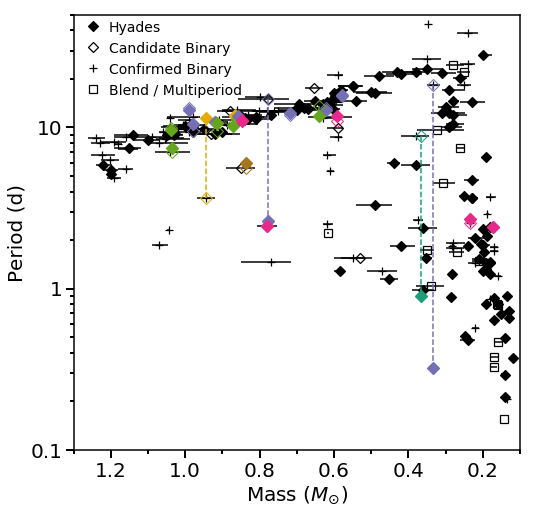

In [49]:
fig = plt.figure(figsize=single_figure)
ax2 = plt.subplot(111)
plot_period_mass(ax=ax2, plot_binaries=True, sources=False, logmass=False, mass_unc=True,
                 which_sources=['H','P','R','D','K','2','3'],qual=0,min_pmem=70,max_bad=0)


diff_set = np.array([])
diff_k2 = np.array([])
diff_lit = np.array([])
for s in ['H','P','R','D','K','2']:
    qual = (pflag==s) & comparison_set
    diff_k2 = np.append(diff_k2,pperiods_onlyk2[qual])
    diff_lit = np.append(diff_lit,pperiods[qual])
    qepic = hdat["EPIC_ID"][qual]
    # Check for significant discrepancies
    diff = abs(pperiods[qual]-pperiods_allk2[qual])/pperiods_allk2[qual]
    sig_diff = np.where(diff>0.1)[0]
    diff_set = np.asarray(np.append(diff_set, np.where(qual)[0][sig_diff]),int)
    # And for secondary periods
    diff_sec = abs(pperiods[qual]-pperiods_secondary[qual])/pperiods_secondary[qual]
    sig_diff_sec = np.where(diff_sec>0.1)[0]
    diff_set_sec = np.asarray(np.append(diff_set, np.where(qual)[0][sig_diff_sec]),int)
    print(s,"With two measurements:",len(np.where(qual)[0]),
          "Significantly different:",len(sig_diff))
    print(qepic[sig_diff])
    print(pperiods[qual][sig_diff])
    print(pperiods_onlyk2[qual][sig_diff])
    
    for i in np.where(qual)[0]:
#         print(i)
        plt.plot([hdat["KH_MASS"][i],hdat["KH_MASS"][i]],[pperiods[i],pperiods_onlyk2[i]],
                 marker="D",color=pcolors[s],ls="--",mfc="none",ms=std_ms)
        plt.plot(hdat["KH_MASS"][i],pperiods_onlyk2[i],
                 "D",color=pcolors[s],ms=std_ms)
#         if (pperiods_secondary[i]>0):
#             plt.plot([hdat["KH_MASS"][i],hdat["KH_MASS"][i]],[pperiods[i],pperiods_secondary[i]],
#                      marker="o",color=pcolors[s],ls="--")
    


In [50]:
diff_frac = abs(diff_k2-diff_lit)/diff_k2
print(min(diff_frac),np.median(diff_frac),np.mean(diff_frac))
print(np.percentile(diff_frac,[20,40,60,80,90]))
print(np.percentile(diff_frac,[25,50,75]))
print(len(diff_frac[diff_frac<0.1]),len(diff_frac),
     len(diff_frac[diff_frac<0.1])/len(diff_frac))

0.0024095991372297234 0.0377843663382016 3.0947428705733744
[0.01820463 0.0222559  0.05816747 0.13188155 3.91521069]
[0.01865649 0.03778437 0.10122587]
17 23 0.7391304347826086


# HIstogram of periodogram powers

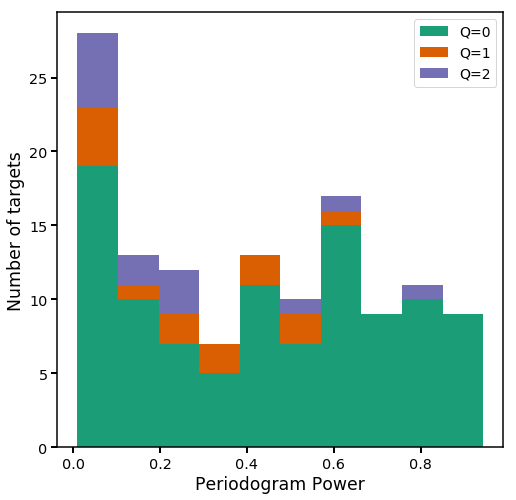

In [51]:
plt.figure(figsize=single_figure)
ax = plt.subplot(111)

good = (pperiods_onlyk2>0)

ax.hist([ppower[good & (pqual==0)], ppower[good & (pqual==1)], ppower[good & (pqual==2)]],
        label=["Q=0","Q=1","Q=2"],histtype="barstacked",color=cmap_qual[:3])

ax.legend(loc=1)
ax.set_xlabel("Periodogram Power",fontsize="xx-large")
ax.set_ylabel("Number of targets",fontsize="xx-large")
ax.tick_params(labelsize="x-large",width=2, length=6)
ax.tick_params(which="minor",width=2, length=3)

[Text(0,0,''), Text(0,0,''), Text(0,0,'0.01'), Text(0,0,'0.1'), Text(0,0,'1')]

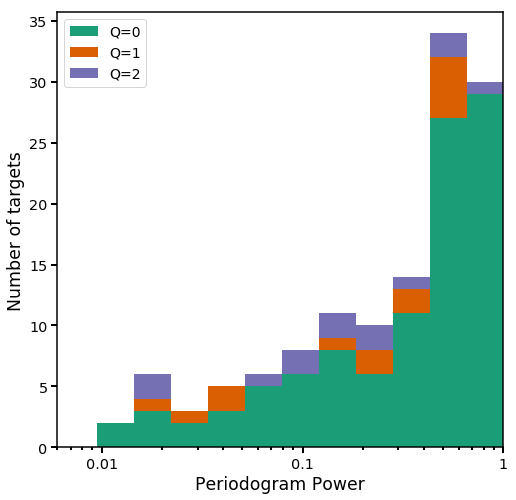

In [52]:
plt.figure(figsize=single_figure)
ax = plt.subplot(111)

good = (pperiods_onlyk2>0)

ax.hist([ppower[good & (pqual==0)], ppower[good & (pqual==1)],
         ppower[good & (pqual==2)]],
        label=["Q=0","Q=1","Q=2"],histtype="barstacked",color=cmap_qual[:3],
        bins=np.logspace(np.log10(min(ppower[ppower>0])),0,12))

ax.set_xlabel("Periodogram Power",fontsize="xx-large")
ax.set_ylabel("Number of targets",fontsize="xx-large")
ax.tick_params(labelsize="x-large",width=2, length=6)
ax.tick_params(which="minor",width=2, length=3)

ax.legend(loc="best")
plt.xscale("log")
plt.xlim(6e-3,1)

ax.set_xticklabels(["","","0.01","0.1","1"],minor=False)

# plt.savefig("/home/stephanie/my_papers/praeK2/powers.pdf",bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig4.pdf",bbox_inches="tight")
# plt.savefig("/home/stephanie/my_papers/praeK2/fig4.eps",bbox_inches="tight")

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


[Text(0,0,''), Text(0,0,'1'), Text(0,0,'10'), Text(0,0,'100')]

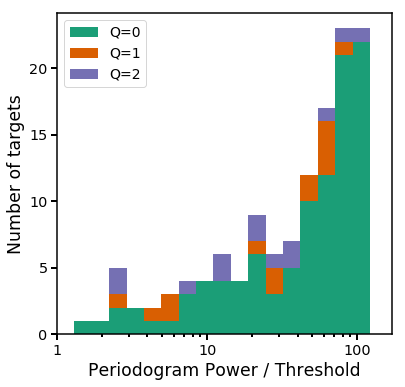

In [53]:
plt.figure(figsize=double_stacked)
ax = plt.subplot(211)

good = (pperiods_onlyk2>0)

ratio = ppower/pthreshold

ax.hist([ratio[good & (pqual==0)], ratio[good & (pqual==1)], ratio[good & (pqual==2)]],
        label=["Q=0","Q=1","Q=2"],histtype="barstacked",color=cmap_qual[:3]
        ,bins=np.logspace(0,2.2,20))

ax.set_xlabel("Periodogram Power / Threshold",fontsize="xx-large")
ax.set_ylabel("Number of targets",fontsize="xx-large")
ax.tick_params(labelsize="x-large",width=2, length=6)
ax.tick_params(which="minor",width=2, length=3)

ax.legend(loc="best")
plt.xscale("log")
plt.xlim(1,170)

ax.set_xticklabels(["","1","10","100"],minor=False)

In [34]:
hdat["PERIOD"][(hdat["PERIOD"]>-99) & (hdat["PERIOD"]<0.01)]

array([], dtype=float32)

In [35]:
hdat["BINARY"][hdat['BINARY']<0]

array([], dtype=float32)